In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from jupyterthemes import jtplot
jtplot.style(gridlines=':')

In [2]:
from reversi import *

### Performance profiling

In [3]:
%%time
%%prun
g = Game(playerB=Player_Random(), playerW=Player_Random())
scores = np.array([g.play(reset=True) for _ in range(5)])

 CPU times: user 300 ms, sys: 8 ms, total: 308 ms
Wall time: 298 ms


In [5]:
%load_ext line_profiler
g = Game(playerB=Player_Random(), playerW=Player_Random())
%lprun -f Board.move scores = np.array([g.play(reset=True) for _ in range(5)])

### Tournament

In [13]:
%%time
t = Tournament(players = [Player_Random(), Player_Greedy(), Player_Weighted()], n=100, diagonal=True)
t.play()

CPU times: user 1min, sys: 20 ms, total: 1min
Wall time: 1min


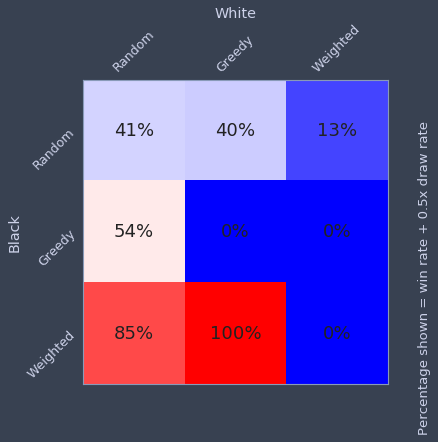

In [25]:
self = t

fig, ax = plt.subplots(1, 1)

ax.set_xlim(-0.5, self.n_players - 0.5)
ax.set_ylim(-0.5, self.n_players - 0.5)

ax.matshow(self.score, cmap=plt.cm.bwr)
for idxB, playerB in enumerate(self.players):
    for idxW, playerW in enumerate(self.players):
        wins = self.wins[idxB, idxW]
        draws = self.draws[idxB, idxW]
        score = self.score[idxB, idxW]
        games = self.n_games
        #score_string = "%d/%d (%d)" % (wins, games, draws) 
        score_string = "%d%%" % (100.*score/games) 
        ax.text(idxW, idxB, score_string,
                verticalalignment='center', horizontalalignment='center',
                color='k', fontsize=18)

ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
ax.set_xticks(range(self.n_players))
ax.set_yticks(range(self.n_players))
player_names = [plr.NAME for plr in self.players]
ax.set_xticklabels(player_names, rotation=45)
ax.set_yticklabels(player_names, rotation=45)
ax.set_xlabel('White')
ax.set_ylabel('Black')
ax.grid()
ax.invert_yaxis()
ax.text(self.n_players-0.2, 0, 'Percentage shown = win rate + 0.5x draw rate', rotation='vertical')

In [12]:
%mprun

ERROR:root:Line magic function `%mprun` not found.
